In [107]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [108]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2 

In [109]:
# --- Data Preparation ---
train_dir = '/kaggle/input/faceshapedataset/men/training_set'
test_dir = '/kaggle/input/faceshapedataset/men/testing_set'

img_size = 224
batch_size = 16

train_datagen = ImageDataGenerator(
    rotation_range=20,
    height_shift_range=0.15,
    shear_range=0.1, 
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator()

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    # shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    # shuffle=False
)

Found 927 images belonging to 4 classes.
Found 384 images belonging to 4 classes.


In [113]:
# --- Model Building ---
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))

In [116]:
base_model.trainable = True
for layer in base_model.layers[:-40]:
    layer.trainable = False

In [117]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.7)(x)
x = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.3)(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

In [118]:
# --- Training ---
epochs = 20

history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=test_generator,
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 66s 541ms/step - accuracy: 0.2680 - loss: 5.6899 - val_accuracy: 0.2734 - val_loss: 5.4763
Epoch 2/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 12s 215ms/step - accuracy: 0.3272 - loss: 5.4188 - val_accuracy: 0.3724 - val_loss: 5.2442
Epoch 3/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 13s 219ms/step - accuracy: 0.4246 - loss: 5.1192 - val_accuracy: 0.4479 - val_loss: 5.0267
Epoch 4/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 13s 217ms/step - accuracy: 0.5055 - loss: 4.9124 - val_accuracy: 0.4870 - val_loss: 4.8359
Epoch 5/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 13s 217ms/step - accuracy: 0.6048 - loss: 4.6013 - val_accuracy: 0.5156 - val_loss: 4.6623
Epoch 6/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 13s 219ms/step - accuracy: 0.6087 - loss: 4.4156 - val_accuracy: 0.5078 - val_loss: 4.5102
Epoch 7/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 13s 215ms/step - accuracy: 0.6794 - loss: 4.1325 - val_accuracy: 0.5156 - val_loss: 4.3613
Epoch 8/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 13s 220ms/step - accuracy: 0.7041 - loss: 3.9646 - val_accu

In [126]:
# Save the entire model (architecture + weights + optimizer state)
model.save('face_shape_model.h5')

# Alternatively, save just the architecture and weights (smaller file)
model.save('face_shape_model.keras')  # .keras is the newer recommended format

In [127]:
import zipfile

# Create a zip file containing your model
with zipfile.ZipFile('model_for_flask.zip', 'w') as zipf:
    zipf.write('face_shape_model.keras')  # or .h5 if you used that
    
    # If you have any custom preprocessing functions, add them too
    # zipf.write('preprocessing.py')

In [128]:
from IPython.display import FileLink

# Create download link
FileLink('model_for_flask.zip')

/kaggle/working/model_for_flask.zip

24/24 ━━━━━━━━━━━━━━━━━━━━ 8s 57ms/step


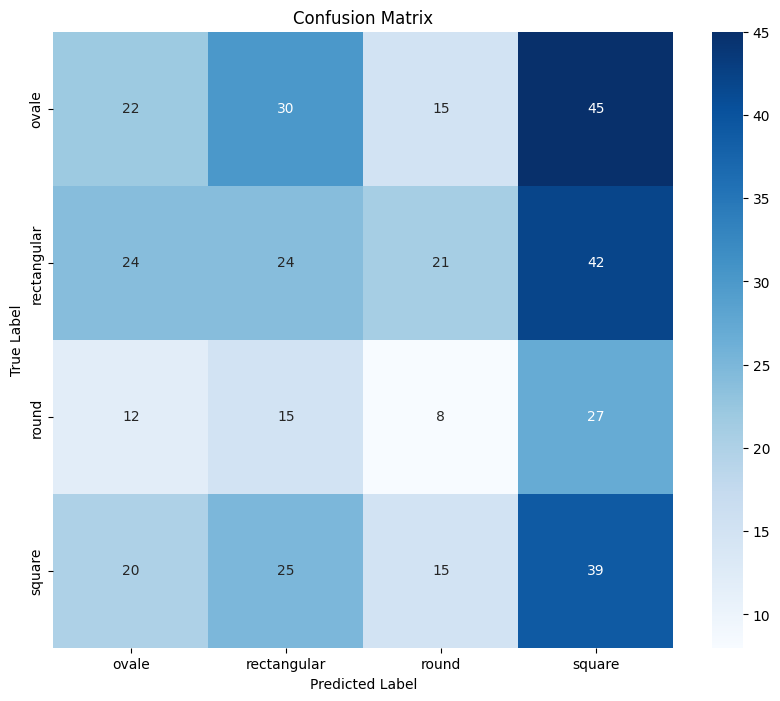


Classification Report:
              precision    recall  f1-score   support

       ovale       0.28      0.20      0.23       112
 rectangular       0.26      0.22      0.23       111
       round       0.14      0.13      0.13        62
      square       0.25      0.39      0.31        99

    accuracy                           0.24       384
   macro avg       0.23      0.23      0.23       384
weighted avg       0.24      0.24      0.24       384



In [119]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import load_model

# Get true labels and predictions
test_generator.reset()
y_true = test_generator.classes
y_pred = model.predict(test_generator, steps=len(test_generator))
y_pred_classes = np.argmax(y_pred, axis=1)

# Get class names
class_names = list(test_generator.class_indices.keys())

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plotting
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Print classification report for more metrics
from sklearn.metrics import classification_report
print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, target_names=class_names))